# Promiscuity mechanisms classifier

This notebook allows the construction, training and evaluation of the Promiscuity classifier

## **Import Necessary Modules**

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install biopython

     |████████████████████████████████| 2.3 MB 5.4 MB/s 


In [3]:
import os
import keras
import numpy as np
from Bio import SeqIO  
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf


## **Dictionary definition**

In [4]:
d = {
    'A': ['GCA', 'GCC', 'GCG', 'GCT'],
    'C': ['TGC', 'TGT'],
    'D': ['GAC', 'GAT'],
    'E': ['GAA', 'GAG'],
    'F': ['TTC', 'TTT'],
    'G': ['GGA', 'GGC', 'GGG', 'GGT'],
    'H': ['CAC', 'CAT'],
    'I': ['ATA', 'ATC', 'ATT'],
    'K': ['AAA', 'AAG'],
    'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'],
    'M': ['ATG'],
    'N': ['AAC', 'AAT'],
    'P': ['CCA', 'CCC', 'CCG', 'CCT'],
    'Q': ['CAA', 'CAG'],
    'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'],
    'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'],
    'T': ['ACA', 'ACC', 'ACG', 'ACT'],
    'V': ['GTA', 'GTC', 'GTG', 'GTT'],
    'W': ['TGG'],
    'Y': ['TAC', 'TAT'],
    '_': ['TAA', 'TAG', 'TGA'],
}

## **Generation of Promiscuity CSVs**


Since the data we downloaded was coded in proteins, the step of reverse translating it into codons has to be performed. To do so, using the table of translation, each protein can be transformed into a codon, with each probability depending on the amount of codons coding for that same protein.

In [13]:
def assemble_sequence(fil): #Function employed to read the .fasta files and extract the useful information
    files= open(fil)
    fasta_sequences = SeqIO.parse(files,'fasta')
    name=[]
    name1=[]
    sequence=[]
    for fasta in fasta_sequences:
        name.append(fasta.id.split("|")[5])
        sequence.append(str(fasta.seq))
    files.close()
    return [name,sequence]
    
path='/content/drive/Shareddrives/iGEM/alexandria/CARD/PROMISCUITY/ICE_aa_all.fas.txt'
dd=assemble_sequence(path) #Generate a list with two lists in it with the different names and sequences
id=[]
for i in range(len(dd[0])):
  dd[0][i]=dd[0][i].lower()
for i in dd[0]:
  ct = 0
  ct2 = 0
  pos1 = i.find('[')
  pos2 = i.find(']')
  name = ''
  for j in range(0,pos1):
    name+=i[j]
  id.append(name)
names=[]
genes=[]
material=[]

def List2String(list): #Function employed for the elimination of spaces in the reverse translated sequence
  space=''
  for element in list:
    space+=element
  return space
total=[]
#The reverse translation is performed using probabilities, hence depending on the amount of codons
#that can code for one protein
for i in dd[1]:
  lista=[]
  for k in i:
    if k in d.keys():
      a=d[k]
      b=np.random.randint(100)
      if len(a)==1:
        k=a
      if len(a)==2:
        if b<=50:
          k=a[0]
        elif b>50:
          k=a[1]
      if len(a)==3:
        if b<=33:
          k=a[0]
        elif b>33 and b<67:
          k=a[1]
        elif b>=67:
          k=a[2]
      if len(a)==4:
        if b<=25:
          k=a[0]
        elif b>25 and b<=50:
          k=a[1]
        elif b>50 and b<=75:
          k=a[2] 
        elif b>75:
          k=a[3]
      if len(a)==5:
        if b<=20:
          k=a[0]
        elif b>20 and b<=40:
          k=a[1]
        elif b>40 and b<=60:
          k=a[2] 
        elif b>60 and b<=80:
          k=a[3]
        elif b>80:
          k=a[4]
      if len(a)==6:
        if b<=100//6:
          k=a[0]
        elif b>100//6 and b<=200//6:
          k=a[1]
        elif b>200//6 and b<=300//6:
          k=a[2] 
        elif b>300//6 and b<=400//6:
          k=a[3]
        elif b>400//6 and b<=500//6:
          k=a[4]  
        elif b>500//6:
          k=a[5]
    k=List2String(k)
    lista.append(k.lower())         
  lista=''.join(lista)
  total.append(lista)
ct=0
ct1=0
ct2=0
#Now from all the data and the specific labels for each sequence,
#We proceed to put new labels ('conjugation' or 'transformation')
#Depending on the previous label for the sequence
for i in range(len(dd[0])):
  if 'hypotheticalprotein' not in dd[0][i]:
    if 'putative' not in dd[0][i]:
      if 'unknown' not in dd[0][i]:
        if '-' not in dd[0][i]:
          if 'hypothetical' not in dd[0][i]:
            if 'unnamedproteinproduct' not in dd[0][i]:
              if 'dnarepairprotein' not in dd[0][i]:
                if 'resistance' not in dd[0][i]:
                  material.append(dd[0][i])
                  if 'conj' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'recombination' in dd[0][i]:
                    names.append('transformation')
                    genes.append(total[i])
                  if 'mobileelementregion' in dd[0][i]:
                    names.append('transformation')
                    genes.append(total[i])
                  if 'ctn' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'mob' in dd[0][i]:
                    names.append('transformation')
                    genes.append(total[i])
                  if 'pilus' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'traq' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trap' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trao' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'tram' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'tral' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trak' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'traj' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trai' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trah' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trag' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'traf' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trae' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trad' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trac' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'trab' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'traa' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'mating' in dd[0][i]:
                    names.append('conjugation')
                    genes.append(total[i])
                  if 'integrase' in dd[0][i]:
                    names.append('transformation')
                    genes.append(total[i])

name1=[]
gene1=[]
for i in range(len(names)):
  if 'conjugation' in names[i]:
    name1.append(names[i])
    gene1.append(genes[i])
  if 'transformation' in names[i]:
    name1.append(names[i])
    gene1.append(genes[i])
newcsv=open('/content/drive/Shareddrives/iGEM/alexandria/CARD/PROMISCUITY/promclassesBETATEST.csv','w')
newcsv.write('resistant,genes'+'\n')
for i in range(len(name1)):
  newcsv.write(name1[i]+','+gene1[i]+'\n')

newcsv.close()

## **CNN architecture and data preprocessing**
Credit to: https://www.kaggle.com/drscarlat/predict-antibiotic-resistance-w-gene-sequence/

In [6]:
def cnn():
  model = Sequential()
  model.add(Embedding(64, 2, input_length=maxlen))
  model.add(layers.Conv1D(128, 243, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 81, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 27, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 9, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.5)))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  model.summary()
  return(model)

In [10]:
DataFrame = pd.read_csv('ADD_YOUR_PATH')#Reading the generated CSV
DataCod = DataFrame.copy()
#Process of conversion from aminoacid sequence to codon sequence
Codons = list(DataCod['genes'])
length = []
for n in range(len(Codons)):
    Codons[n] = list([Codons[n][i:i+3] for i in range(0, len(Codons[n]), 3)])
    length.append(len(Codons[n]))
    
DataCod['codons'] = Codons
#The maximum length will be used for the padding of sequences
maxlen = max(length) 

max_words = 64 # Number of words in the dictionary, equal to the number of  possible codons
max_features = max_words

#tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(DataCod['codons']))
sequences = tokenizer.texts_to_sequences(list(DataCod['codons']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

# This step ensures that the generated dictionary has exactly what we asked for since in some cases words that are not codons are generated
new_dict= {'cac', 'cgt', 'aat', 'atg', 'tac', 'att', 'tgg', 'gac', 'tgc', 'act', 'gtt', 'gaa', 'aaa', 'cag', 'tga', 'ttg', 'gct', 'ttc', 'tct', 'ggc', 'aca', 'taa', 'ctg', 'ata', 'caa', 'ctt', 'tcg', 'gtc', 'aac', 'gga', 'acg', 'gca', 'tta', 'cta', 'acc', 'gat', 'tca', 'tat', 'agg', 'tgt', 'gtg', 'cga', 'cgc', 'ttt', 'aga', 'ggt', 'ctc', 'cca', 'ccg', 'gcg', 'a', 'ga', 'tag', 'atc', 'cat', 'agt', 'cgg', 'aag', 'gag', 'cct', 'gta', 'ggg', 'tcc', 'agc', 'ccc', 'gcc'}
unwanted= set(word_index) - set(new_dict)
for unwanted_key in unwanted: del word_index[unwanted_key]


# Separate the label

labels = np.asarray(DataCod['resistant'])


training_samples = int(Xpad.shape[0] * 0.8) # This number will be used to separate between train set (80% of data) and test set (20% of data)


indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) #Shuffle all the data to better train the CNN
Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples:]
y_test = labels[training_samples:]

#Labels need to be encoded as well like the sequences. Hence,
#the label encoder is employed to do this task and obtain
#encoded labels
encoder=LabelEncoder()
encoder.fit(y_train)
encoded_Y=encoder.transform(y_train)

encoder1=LabelEncoder()
encoder1.fit(y_test)
encoded_Y1=encoder1.transform(y_test)
y=np_utils.to_categorical(encoded_Y)
y_test=np_utils.to_categorical(encoded_Y1)
model = cnn()


3066
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1733, 2)           128       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1491, 128)         62336     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 497, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 497, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 417, 128)          1327232   
_________________________________________________________________
dropout_5 (Dropout)          (None, 417, 128)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 391, 128)    

## **Fit and save the model**
Paths must be changed

In [ ]:
history = model.fit(x_train, y, epochs = 10, batch_size=16, validation_split=0.2)

model.save('ADD_YOUR_PATH')

## **Metrics calculation and first prediction, individual labels**
With this cell you can input the path of the saved model and look at the confusion matrix and classification report for the promiscuity mechanisms.

Credit for the function for plotting the matrix in a beatiful manner and the probability treshold decision to: 
https://www.kaggle.com/drscarlat/predict-antibiotic-resistance-w-gene-sequence/

20/20 [==============================] - 1s 38ms/step - loss: 0.0799 - acc: 0.9788
Metrics Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       507
           1       0.94      0.93      0.94       107

   micro avg       0.98      0.98      0.98       614
   macro avg       0.96      0.96      0.96       614
weighted avg       0.98      0.98      0.98       614
 samples avg       0.98      0.98      0.98       614



<Figure size 432x288 with 0 Axes>

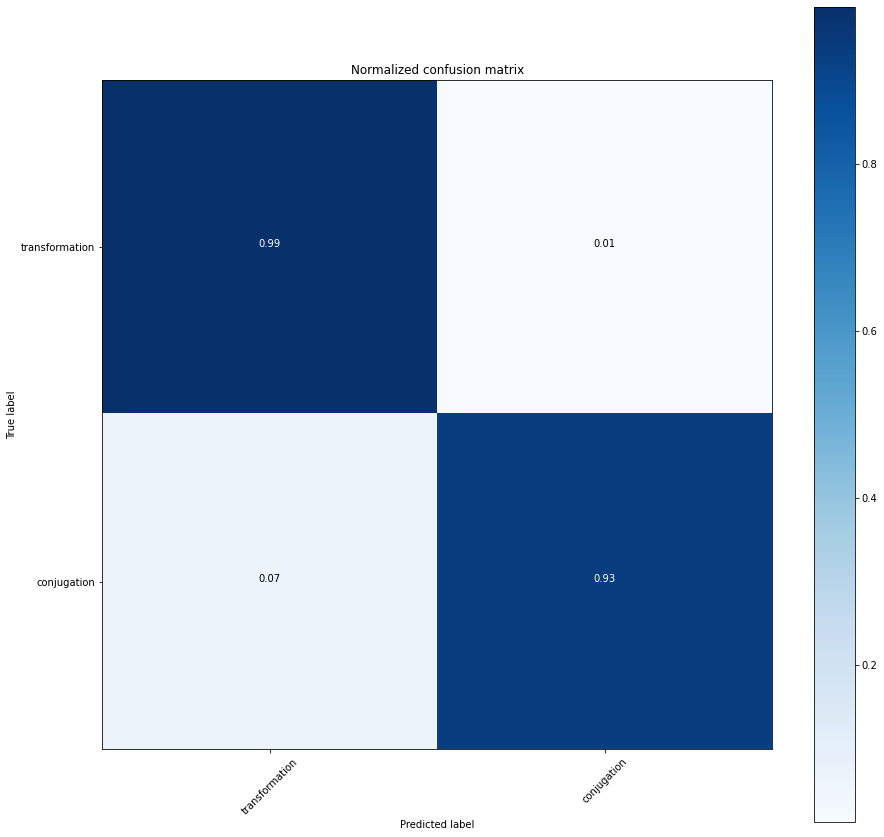

In [11]:
model = keras.models.load_model('ADD_YOUR_PATH')
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def separate_metrics(matrix,cyst):
  TP=matrix[cyst][cyst]
  FN=sum(matrix[cyst,:])-TP
  FP=sum(matrix[:,cyst])-TP
  TN=sum(sum(matrix))-TP-FP-FN
  return TP,FP,TN,FN
  
final_predictions = model.predict(x_test)#We use keras to predict the mechanisms of the test set, the predicitons are arrays of 2 positions with the probability to belong to each label
evaluate=model.evaluate(x_test,y_test)# We can obtain the metrics for accuracy in the test set in a direct manner by putting the labels
# An important step is to transform the probabilities to binary decisions (either you belong to a label or not), we used the typical treshold in literature of 0.5
Preds = final_predictions.copy()
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0

print('Metrics Report: ')
conf_mx = classification_report(y_test, Preds)
print(conf_mx)

y_pred = [np.argmax(probas) for probas in final_predictions]
y_test_int = np.argmax(y_test, axis=1)

class_names = ['transformation','conjugation']

from sklearn.metrics import confusion_matrix
import itertools
#Function to plot a generated confusion matrix from Alexander Scarlat, you can select the colormap, light or dark theme and the figure size
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test_int, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()